In [1]:
# Install a conda package in the current Jupyter kernel
import sys

In [ ]:
!conda install --yes --prefix {sys.prefix} numpy

In [1509]:
import numpy as np

class softmax:
    def gradient(self, X, Y, error, W):
        M = X.shape[1]
        grad_theta = 1/M * X.dot(error.T)
        grad_b = 1/M * np.sum(error, axis=1)
        grad_data = 1/M * W.dot(error)
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        exp = np.exp(x)
        return (exp / np.sum(exp, axis=0))

In [1510]:
class tanh:
    def gradient(self, X, Y, error, W):
        error = (1- Y**2) * error
        grad_theta = X.dot(error.T)
        grad_b = np.sum(error, axis=1)
        grad_data = W.dot(error)
        return grad_theta, grad_b, grad_data
        
    def __call__(self, x):
        return np.tanh(x)

In [1511]:
class linear_layer:
    def __init__(self, dim_in, dim_out, activation=tanh()):
        self._A = np.random.normal(.5, .5, size=(dim_in, dim_out))
        self._B = np.random.normal(.5, .5, size=(dim_out, 1))
        self._activation = activation
        self._dim_in = dim_in
        self._dim_out = dim_out
        
    def update_weigths(self, gradient_theta, gradient_b, learning_rate):
        gradient_b = gradient_b.reshape(self._dim_out, 1)
        self._A = self._A - learning_rate * gradient_theta
        self._B = self._B - learning_rate * gradient_b
    
    def gradient(self, X, Y, error):
        return self._activation.gradient(X, Y, error, self._A)
    
    def dim_in(self):
        return self._dim_in
    
    def dim_out(self):
        return self._dim_out
    
    def __call__(self, x):
        return self._activation(self._A.T.dot(x) + self._B)

In [1512]:
def cross_entropy_loss(y_true, y_predicted, epsilon=1e-10):
    predictions = np.clip(y_predicted, epsilon, 1. - epsilon)
    M = predictions.shape[1]
    return -np.sum(y_true * np.log(predictions)) / M

In [1529]:
class sequential_model:
    def __init__(self, *layers, learning_rate=0.1):
        self._learning_rate = learning_rate
        self._layers = []
        self._outputs = []
        last_dim_out = 0
        for layer in layers:
            if last_dim_out != 0 and last_dim_out != layer.dim_in():
                print('dimension dont match layer out dim {} , next layer dim in {}'.format(last_dim_out, layer.dim_in()))
                raise 
            self._layers.append(layer)
            last_dim_out = layer.dim_out()
                
    def update_weigths(self, Y_true):
        error = self._outputs[-1] - Y_true
        for i in range(1, len(self._layers) + 1):
            X = self._outputs[-i - 1]
            Y = self._outputs[-i]
            gradient_theta, gradient_b, error = self._layers[-i].gradient(X, Y, error)
            self._layers[-i].update_weigths(gradient_theta, gradient_b, self._learning_rate)
            
    def __call__(self, x):
        new_x = np.array(x, copy=True) 
        self._outputs = []
        self._outputs.append(new_x)
        for layer in self._layers:
            new_x = layer(new_x)
            self._outputs.append(new_x)
        return new_x

In [1530]:
model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

In [1531]:
!conda install --yes --prefix {sys.prefix} scipy

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.10.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [1532]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')

In [1533]:
X = mat['Yt']
Y = mat['Ct']
print(X.shape)
print(Y.shape)

(2, 25000)
(5, 25000)


In [1534]:
Y_predicted = model(X)
print(Y_predicted.shape)
print(Y_predicted.sum(axis=0))

(5, 25000)
[1. 1. 1. ... 1. 1. 1.]


In [1535]:
print(cross_entropy_loss(Y, Y_predicted))

2.033730540597164


In [1536]:
def accuracy(Y_true, Y_predicted):
    return np.sum(np.argmax(Y_true, axis=0) == np.argmax(Y_predicted, axis=0)) / Y_true.shape[1]

In [1537]:
def SGD(model, X, Y, epoch):
    loss = []
    accuracy_sgd = []
    for i in range(epoch):
        Y_predicted = model(X)
        model.update_weigths(Y)
        accuracy_sgd.append(accuracy(Y, Y_predicted))
        loss.append(cross_entropy_loss(Y, Y_predicted))
    return loss, accuracy_sgd

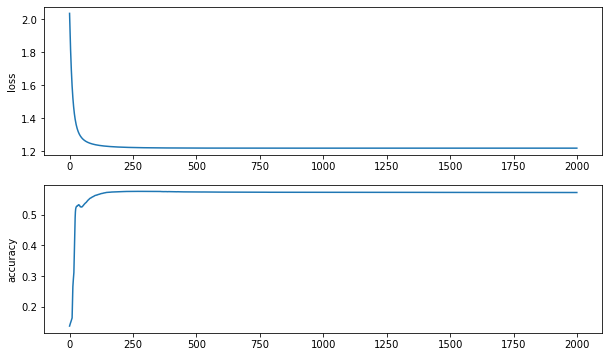

In [1538]:
import matplotlib.pyplot as plt

model_loss, model_accuracy = SGD(model, X, Y, 2000)

#fig = plt.figure(figsize=(10,6))

fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(model_loss)
axs[0].set_ylabel('loss')

axs[1].plot(model_accuracy)
axs[1].set_ylabel('accuracy')

plt.show()

In [1683]:
def gradient_test_with_respect_to_inputs(function, gradient, activation, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    weights = np.random.normal(.5, .5, size=(dim_in, dim_out))
    biases = np.random.normal(.5, .5, size=(dim_out, 1))
    d = np.random.normal(.5, .5, size=(dim_in, 1))
    d = d / np.linalg.norm(d)
    without_jacobain = []
    with_jacobain = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = activation(weights.T.dot(X) + biases)
        predictions_d = activation(weights.T.dot(X + vec) + biases)
        diff_f = function(Y, predictions_d) - function(Y, predictions)
        without_jacobain.append(np.abs(diff_f))
        grad_theta, grad_b, grad_data = gradient(X, Y, predictions, weights)
        with_jacobain.append(np.linalg.norm(diff_f - vec.T.dot(grad_data)))
    return without_jacobain, with_jacobain

In [1702]:
def softmax_gradient(X, Y_true, Y_predicted, W):
    grad = Y_predicted - Y_true
    grad_theta = X.dot(grad.T)
    grad_b = np.sum(grad, axis=1)
    grad_data = W.dot(grad)
    return grad_theta, grad_b.reshape(Y_true.shape[0], 1), grad_data

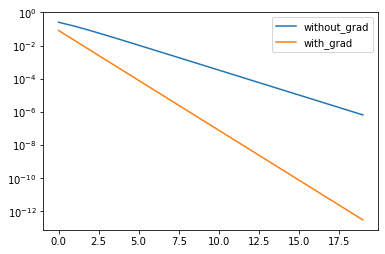

In [1685]:
test_model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

without_grad, with_grad = gradient_test_with_respect_to_inputs(cross_entropy_loss, softmax_gradient, softmax(), X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.plot(without_grad, label='without_grad')

plt.plot(with_grad, label='with_grad')

plt.yscale('log')

plt.legend()

plt.show()

In [1703]:
def gradient_test_with_respect_to_baises(function, gradient, activation, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    weights = np.random.normal(.5, .5, size=(dim_in, dim_out))
    biases = np.random.normal(.5, .5, size=(dim_out, 1))
    d = np.random.normal(.5, .5, size=(dim_out, 1))
    d = d / np.linalg.norm(d)
    without_jacobain = []
    with_jacobain = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = activation(weights.T.dot(X) + biases)
        predictions_d = activation(weights.T.dot(X) + (biases + vec))
        diff_f = function(Y, predictions_d) - function(Y, predictions)
        without_jacobain.append(np.abs(diff_f))
        _, grad_baises, _ = gradient(X, Y, predictions, weights)
        with_jacobain.append(np.linalg.norm(diff_f - vec.T.dot(grad_baises)))
    return without_jacobain, with_jacobain

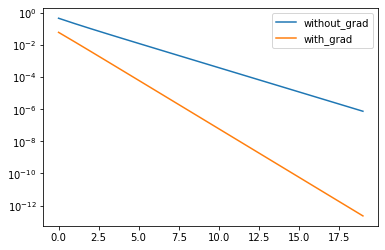

In [1705]:
test_model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

without_grad, with_grad = gradient_test_with_respect_to_baises(cross_entropy_loss, softmax_gradient, softmax(), X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.plot(without_grad, label='without_grad')

plt.plot(with_grad, label='with_grad')

plt.yscale('log')

plt.legend()

plt.show()

In [1726]:
def gradient_test_with_respect_to_weigths(function, gradient, activation, X, Y):
    dim_out = Y.shape[0]
    dim_in = X.shape[0]
    weights = np.random.normal(.5, .5, size=(dim_in, dim_out))
    biases = np.random.normal(.5, .5, size=(dim_out, 1))
    d = np.random.normal(.5, .5, size=(dim_in, dim_out))
    d = d / np.linalg.norm(d)
    without_jacobain = []
    with_jacobain = []
    for i in range(20):
        e = np.power(0.5, i)
        vec = e * d
        predictions = activation(weights.T.dot(X) + biases)
        predictions_d = activation((weights + vec).T.dot(X) + biases)
        diff_f = function(Y, predictions_d) - function(Y, predictions)
        without_jacobain.append(np.abs(diff_f))
        grad_theta, _, _ = gradient(X, Y, predictions, weights)
        with_jacobain.append(np.linalg.norm(diff_f - (np.ravel(vec) @ np.ravel(grad_theta))))
    return without_jacobain, with_jacobain

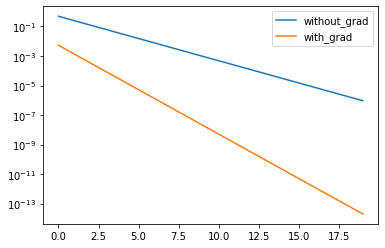

In [1727]:
test_model = sequential_model(
        linear_layer(2, 5, activation=softmax())
        )

without_grad, with_grad = gradient_test_with_respect_to_weigths(cross_entropy_loss, softmax_gradient, softmax(), X[:, 0].reshape(2,1), Y[:, 0].reshape(5,1))

plt.plot(without_grad, label='without_grad')

plt.plot(with_grad, label='with_grad')

plt.yscale('log')

plt.legend()

plt.show()

In [1624]:
model = sequential_model(
        linear_layer(2, 4, activation=tanh()),
        linear_layer(4, 8, activation=tanh()),
        linear_layer(8, 5, activation=softmax())
)

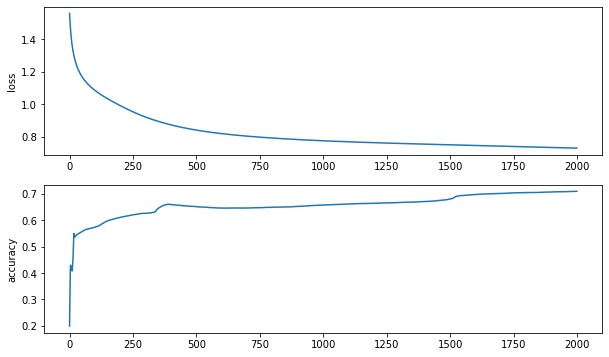

In [1543]:
model_loss, model_accuracy = SGD(model, X, Y, 2000)

#fig = plt.figure(figsize=(10,6))

fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(model_loss)
axs[0].set_ylabel('loss')

axs[1].plot(model_accuracy)
axs[1].set_ylabel('accuracy')

plt.show()